In [1]:
import detectron2
import torch
import copy
import pickle 
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from detectron2.data import DatasetCatalog
from detectron2.data import MetadataCatalog
import detectron2.data.transforms as T
from detectron2.data import DatasetMapper   # the default mapper
from detectron2.data import build_detection_train_loader
from detectron2.data import build_detection_test_loader
from detectron2.data import detection_utils as utils 
from detectron2.data.detection_utils import annotations_to_instances

/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/anaconda3/envs/detectron2/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#for the mapepr
import copy
import logging
import numpy as np
from typing import List, Optional, Union
import torch

from detectron2.config import configurable

from detectron2.data import detection_utils as utils 
import detectron2.data.transforms as T

In [3]:
torch.__version__

'1.10.0'

In [4]:
!nvidia-smi

Fri Jan 20 22:51:39 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   40C    P0    54W / 300W |      0MiB / 32768MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   

# Register the dataset so that it can be used by dataloader

In [5]:
def get_detectron_train_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "327_A1d_ASAP.xml",
        "270_A1d_ASAP.xml", #may need to remove this, bc this is at the wrong level. 
        "131_B1e_ASAP_fixed.xml", 
        "41_A2c_ASAP_fixed.xml", 
        "51_D1b_ASAP_fixed.xml"
        
    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [6]:
def get_detectron_test_data():
    data = [] #here is where we will collect the coco dicts
    root = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/DetectronData/"
    xml_files = [
        "281_A1f_ASAP.xml",

    ]
    for id in xml_files: #collect all of the individual WSI data 
        sample_id = id.split(".")[0]
        sample_data = None
        filepath = str(root + sample_id+".pickle")
        with open(filepath, 'rb') as handle:
            sample_data = pickle.load(handle)
        sample_data 
        for patch_info in sample_data:
            data.append(patch_info)
    return data


In [7]:
train_data = get_detectron_train_data()
test_data = get_detectron_test_data()

In [8]:
# new_data = test_data[15:]
# print(len(new_data))
# test_data = test_data[:15]
# for d in new_data:
#     train_data.append(d)

In [9]:
print(len(train_data), len(test_data))

1173 115


In [10]:
DatasetCatalog.register("nuclei_detection_train", get_detectron_train_data)
DatasetCatalog.register("nuclei_detection_test", get_detectron_test_data)

In [11]:
MetadataCatalog.get("nuclei_detection_train").thing_classes = ["cell"] 
MetadataCatalog.get("nuclei_detection_test").thing_classes = ["cell"] 

In [97]:
# from detectron2.data import transforms as T

# build_train_augmentations = lambda cfg: [
#     T.ResizeShortestEdge(
#             cfg.INPUT.MIN_SIZE_TRAIN, cfg.INPUT.MAX_SIZE_TRAIN, cfg.INPUT.MIN_SIZE_TRAIN_SAMPLING
#         ),
#     T.RandomBrightness(0.5, 2),
#     T.RandomContrast(0.5, 2),
#     T.RandomSaturation(0.5, 2),
#     T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
#     T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
# ]

In [12]:
# mapper = DatasetMapper(is_train=True,
#                          augmentations=[ 
#                                 T.RandomBrightness(0.5, 2),
#                                 T.RandomContrast(0.5, 2),
#                                 T.RandomSaturation(0.5, 2),
#                                 T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
#                                 T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
#                          ], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR")

In [13]:
# mapper(train_data[0])

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/Images/327_A1d_ASAP_0.jpg',
 'height': 128,
 'width': 128,
 'image_id': '327_A1d_ASAP_0',
 'image': tensor([[[223, 217, 224,  ..., 185, 178, 159],
          [213, 219, 226,  ..., 188, 168, 150],
          [207, 224, 225,  ..., 185, 147, 132],
          ...,
          [222, 221, 219,  ..., 202, 217, 203],
          [213, 211, 210,  ..., 191, 202, 185],
          [221, 214, 208,  ..., 172, 188, 184]],
 
         [[189, 184, 189,  ..., 135, 124, 103],
          [179, 186, 191,  ..., 138, 114,  94],
          [173, 188, 188,  ..., 137,  95,  78],
          ...,
          [195, 194, 192,  ..., 156, 171, 157],
          [186, 184, 183,  ..., 145, 156, 139],
          [194, 187, 181,  ..., 126, 142, 138]],
 
         [[226, 219, 223,  ..., 165, 153, 132],
          [216, 221, 225,  ..., 168, 144, 123],
          [210, 224, 222,  ...

In [12]:
# # we create the train dataloader here. Might make sense to play around with batch_size.
# train_dataloader = build_detection_train_loader(
#     train_data,
#     mapper=DatasetMapper(is_train=True,
#                          augmentations=[ 
#                                 T.RandomBrightness(0.5, 2),
#                                 T.RandomContrast(0.5, 2),
#                                 T.RandomSaturation(0.5, 2),
#                                 T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
#                                 T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
#                          ], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR"), 
#     total_batch_size = 1, 
#     )

In [13]:
# test_dataloader = build_detection_test_loader(
#     test_data,
#     mapper=DatasetMapper(
#                          augmentations=[], 
#                          use_instance_mask = True, 
#                          instance_mask_format = "polygon",
#                          image_format="BGR"), 
#     )

In [14]:
data = None
for x in train_dataloader:
    print(x[0]["instances"])
    data = x
    break

Instances(num_instances=5, image_height=128, image_width=128, fields=[gt_boxes: Boxes(tensor([[ 7.4082, 26.7656, 17.6152, 38.7656],
        [18.0273, 28.1465, 33.7520, 43.0410],
        [13.6152, 41.3848, 27.4062, 53.2461],
        [ 5.6152, 50.4883, 17.0625, 60.2813],
        [ 0.2363, 61.2461, 11.8223, 74.2109]])), gt_classes: tensor([0, 0, 0, 0, 0]), gt_masks: PolygonMasks(num_instances=5)])


# Visualize Training Data

In [15]:
from detectron2.utils.visualizer import ColorMode, Visualizer
data

[{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/Images/41_A2c_ASAP_fixed_18.jpg',
  'height': 128,
  'width': 128,
  'image_id': '41_A2c_ASAP_fixed_18',
  'image': tensor([[[ 85,  87,  78,  ...,  63,  63,  64],
           [ 83,  89,  87,  ...,  76,  76,  78],
           [ 92,  87,  78,  ...,  73,  74,  78],
           ...,
           [ 64,  71,  71,  ...,  59,  50,  46],
           [ 66,  74,  89,  ...,  52,  48,  53],
           [ 63,  74, 101,  ...,  67,  63,  65]],
  
          [[ 41,  51,  47,  ...,  29,  25,  21],
           [ 35,  46,  53,  ...,  39,  35,  32],
           [ 44,  42,  39,  ...,  32,  29,  30],
           ...,
           [ 21,  33,  34,  ...,  15,  12,  11],
           [ 23,  33,  51,  ...,  13,  12,  13],
           [ 22,  31,  57,  ...,  32,  25,  25]],
  
          [[ 67,  64,  52,  ...,  47,  46,  45],
           [ 49,  58,  61,  ...,  58,  54,  5

In [16]:
data[0]

{'file_name': '/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/Data/Images/41_A2c_ASAP_fixed_18.jpg',
 'height': 128,
 'width': 128,
 'image_id': '41_A2c_ASAP_fixed_18',
 'image': tensor([[[ 85,  87,  78,  ...,  63,  63,  64],
          [ 83,  89,  87,  ...,  76,  76,  78],
          [ 92,  87,  78,  ...,  73,  74,  78],
          ...,
          [ 64,  71,  71,  ...,  59,  50,  46],
          [ 66,  74,  89,  ...,  52,  48,  53],
          [ 63,  74, 101,  ...,  67,  63,  65]],
 
         [[ 41,  51,  47,  ...,  29,  25,  21],
          [ 35,  46,  53,  ...,  39,  35,  32],
          [ 44,  42,  39,  ...,  32,  29,  30],
          ...,
          [ 21,  33,  34,  ...,  15,  12,  11],
          [ 23,  33,  51,  ...,  13,  12,  13],
          [ 22,  31,  57,  ...,  32,  25,  25]],
 
         [[ 67,  64,  52,  ...,  47,  46,  45],
          [ 49,  58,  61,  ...,  58,  54,  54],
          [ 53,  5

In [17]:
data[0]["instances"].gt_classes

tensor([0, 0, 0, 0, 0])

In [18]:
data[0]["image"].shape

torch.Size([3, 128, 128])

In [19]:
img = cv2.imread(data[0]["file_name"])

In [20]:
v = Visualizer(img)

In [21]:
v = v.overlay_instances(boxes=data[0]["instances"].gt_boxes, labels=data[0]["instances"].gt_classes.numpy(), masks=data[0]["instances"].gt_masks)

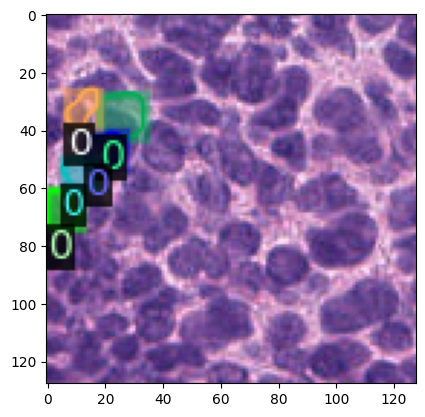

In [22]:
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

# Training the Segmentation Model

In [70]:
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg

In [71]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml"))
cfg.DATASETS.TRAIN = "nuclei_detection_train"
cfg.DATASETS.TEST = "nuclei_detection_test"
cfg.MODEL.DEVICE = "cuda"
cfg.DATALOADER.NUM_WORKERS = 20
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_1x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32  # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.BASE_LR = 5e-3
cfg.SOLVER.MAX_ITER = 10000
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1

In [73]:
class Trainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        mapper=DatasetMapper(is_train=True,
             augmentations=[ 
                    T.RandomBrightness(0.5, 2),
                    T.RandomContrast(0.5, 2),
                    T.RandomSaturation(0.5, 2),
                    T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
                    T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
             ], 
             use_instance_mask = True, 
             instance_mask_format = "polygon",
             image_format="BGR"
        )
        return build_detection_train_loader(cfg, mapper=mapper)

In [74]:
trainer = Trainer(cfg) 
trainer.resume_or_load(resume=False)

[01/20 23:21:23 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[01/20 23:21:23 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in training: [RandomBrightness(intensity_min=0.5, intensity_max=2), RandomContrast(intensity_min=0.5, intensity_max=2), RandomSaturation(intensity_min=0.5, intensity_max=2), RandomFlip(prob=0.5), RandomFlip(prob=0.5, horizontal=False, vertical=True)]
[01/20 23:21:32 d2.data.build]: Removed 0 images with no usable annotations. 1173 images left.
[01/20 23:21:32 d2.data.build]: Using training sampler TrainingSampler
[01/20 23:21:32 d2.data.common]: Serializing 1173 elements to byte tensors and concatenating them all ...
[01/20 23:22:18 d2.data.common]: Serialized dataset takes 586.24 MiB
WARNING [01/20 23:22:19 d2.solver.build]: SOLVER.STEPS contains values larger than SOLVER.MAX_ITER. These values will be ignored.


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

In [75]:
trainer.train()

[01/20 23:23:59 d2.engine.train_loop]: Starting training from iteration 0
[01/20 23:24:03 d2.utils.events]:  eta: 0:12:45  iter: 19  total_loss: 4.125  loss_cls: 0.6238  loss_box_reg: 0.6935  loss_mask: 0.685  loss_rpn_cls: 1.776  loss_rpn_loc: 0.3916  time: 0.0809  data_time: 0.1245  lr: 9.9905e-05  max_mem: 1142M
[01/20 23:24:05 d2.utils.events]:  eta: 0:13:59  iter: 39  total_loss: 2.805  loss_cls: 0.4878  loss_box_reg: 0.8051  loss_mask: 0.6346  loss_rpn_cls: 0.5359  loss_rpn_loc: 0.3535  time: 0.0926  data_time: 0.0213  lr: 0.0001998  max_mem: 1142M
[01/20 23:24:07 d2.utils.events]:  eta: 0:12:58  iter: 59  total_loss: 2.541  loss_cls: 0.4083  loss_box_reg: 0.7534  loss_mask: 0.5308  loss_rpn_cls: 0.4957  loss_rpn_loc: 0.3884  time: 0.0860  data_time: 0.0067  lr: 0.0002997  max_mem: 1142M
[01/20 23:24:08 d2.utils.events]:  eta: 0:12:00  iter: 79  total_loss: 2.232  loss_cls: 0.346  loss_box_reg: 0.7947  loss_mask: 0.4361  loss_rpn_cls: 0.3861  loss_rpn_loc: 0.2775  time: 0.0806  d

[01/20 23:25:06 d2.utils.events]:  eta: 0:10:07  iter: 699  total_loss: 1.588  loss_cls: 0.2222  loss_box_reg: 0.6222  loss_mask: 0.3399  loss_rpn_cls: 0.2297  loss_rpn_loc: 0.2147  time: 0.0908  data_time: 0.0121  lr: 0.0034965  max_mem: 1142M
[01/20 23:25:08 d2.utils.events]:  eta: 0:10:06  iter: 719  total_loss: 1.652  loss_cls: 0.2729  loss_box_reg: 0.5847  loss_mask: 0.3418  loss_rpn_cls: 0.2803  loss_rpn_loc: 0.2171  time: 0.0903  data_time: 0.0087  lr: 0.0035964  max_mem: 1142M
[01/20 23:25:09 d2.utils.events]:  eta: 0:10:04  iter: 739  total_loss: 1.677  loss_cls: 0.2319  loss_box_reg: 0.6075  loss_mask: 0.3196  loss_rpn_cls: 0.2885  loss_rpn_loc: 0.1806  time: 0.0897  data_time: 0.0046  lr: 0.0036963  max_mem: 1142M
[01/20 23:25:11 d2.utils.events]:  eta: 0:10:02  iter: 759  total_loss: 1.846  loss_cls: 0.2704  loss_box_reg: 0.6519  loss_mask: 0.3387  loss_rpn_cls: 0.2956  loss_rpn_loc: 0.2983  time: 0.0892  data_time: 0.0058  lr: 0.0037962  max_mem: 1142M
[01/20 23:25:12 d2.u

[01/20 23:25:55 d2.utils.events]:  eta: 0:09:14  iter: 1379  total_loss: 1.684  loss_cls: 0.2402  loss_box_reg: 0.6015  loss_mask: 0.3394  loss_rpn_cls: 0.2706  loss_rpn_loc: 0.238  time: 0.0807  data_time: 0.0097  lr: 0.005  max_mem: 1142M
[01/20 23:25:57 d2.utils.events]:  eta: 0:09:12  iter: 1399  total_loss: 1.722  loss_cls: 0.262  loss_box_reg: 0.599  loss_mask: 0.3372  loss_rpn_cls: 0.2728  loss_rpn_loc: 0.1945  time: 0.0807  data_time: 0.0134  lr: 0.005  max_mem: 1142M
[01/20 23:25:58 d2.utils.events]:  eta: 0:09:11  iter: 1419  total_loss: 1.682  loss_cls: 0.2316  loss_box_reg: 0.6092  loss_mask: 0.3253  loss_rpn_cls: 0.2265  loss_rpn_loc: 0.2554  time: 0.0808  data_time: 0.0187  lr: 0.005  max_mem: 1142M
[01/20 23:26:00 d2.utils.events]:  eta: 0:09:09  iter: 1439  total_loss: 1.521  loss_cls: 0.2775  loss_box_reg: 0.5757  loss_mask: 0.3144  loss_rpn_cls: 0.2174  loss_rpn_loc: 0.2118  time: 0.0806  data_time: 0.0057  lr: 0.005  max_mem: 1142M
[01/20 23:26:01 d2.utils.events]:  

[01/20 23:26:45 d2.utils.events]:  eta: 0:08:39  iter: 2059  total_loss: 1.503  loss_cls: 0.2183  loss_box_reg: 0.5487  loss_mask: 0.3168  loss_rpn_cls: 0.2092  loss_rpn_loc: 0.1971  time: 0.0777  data_time: 0.0041  lr: 0.005  max_mem: 1142M
[01/20 23:26:46 d2.utils.events]:  eta: 0:08:38  iter: 2079  total_loss: 1.665  loss_cls: 0.2285  loss_box_reg: 0.6213  loss_mask: 0.3437  loss_rpn_cls: 0.2098  loss_rpn_loc: 0.222  time: 0.0776  data_time: 0.0057  lr: 0.005  max_mem: 1142M
[01/20 23:26:48 d2.utils.events]:  eta: 0:08:37  iter: 2099  total_loss: 1.601  loss_cls: 0.2292  loss_box_reg: 0.5464  loss_mask: 0.3281  loss_rpn_cls: 0.2053  loss_rpn_loc: 0.2171  time: 0.0776  data_time: 0.0094  lr: 0.005  max_mem: 1142M
[01/20 23:26:49 d2.utils.events]:  eta: 0:08:35  iter: 2119  total_loss: 1.644  loss_cls: 0.2485  loss_box_reg: 0.6142  loss_mask: 0.32  loss_rpn_cls: 0.2199  loss_rpn_loc: 0.2554  time: 0.0775  data_time: 0.0041  lr: 0.005  max_mem: 1142M
[01/20 23:26:51 d2.utils.events]:  

KeyboardInterrupt: 

# Inference using Model 

In [104]:
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = .2
predictor = DefaultPredictor(cfg)

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

## Inference on test image

In [105]:
outputs = predictor(img)

In [106]:
len(outputs["instances"])

100

In [107]:
outputs["instances"]._fields

{'pred_boxes': Boxes(tensor([[ 46.5743,  53.0756,  65.7240,  72.6349],
         [ 63.5417,  79.4555,  83.8654,  99.0627],
         [ 59.9940,  50.4043,  78.5734,  71.9059],
         [ 36.1365,  61.8695,  56.1177,  82.2732],
         [ 76.1957,  38.1751,  93.0854,  58.0304],
         [ 58.6324, 101.6427,  82.3761, 123.7690],
         [ 20.1103,  63.7069,  40.6446,  84.7651],
         [ 24.5340,  84.9068,  44.3881, 104.1159],
         [ 70.2649,  82.3820,  97.3856,  99.1660],
         [ 64.0187,  45.0152,  85.0239,  67.1048],
         [ 54.8814,  97.7519,  74.9963, 118.0781],
         [ 75.6848, 105.5935,  94.3700, 124.3699],
         [  3.2841,  32.8434,  42.7227,  80.9185],
         [ 75.8770,  67.1269,  81.0638,  71.2739],
         [ 43.8924,  58.7231,  64.6092,  79.4447],
         [ 71.7664,  19.9428,  89.5281,  51.4414],
         [ 69.6314,  49.0176,  89.2094,  68.6378],
         [ 92.0052,  26.2422, 117.6974,  50.5741],
         [ 38.4512,  30.2254,  64.2471,  51.9154],
         [ 

In [108]:
outputs["instances"].to("cpu")

Instances(num_instances=100, image_height=128, image_width=128, fields=[pred_boxes: Boxes(tensor([[ 46.5743,  53.0756,  65.7240,  72.6349],
        [ 63.5417,  79.4555,  83.8654,  99.0627],
        [ 59.9940,  50.4043,  78.5734,  71.9059],
        [ 36.1365,  61.8695,  56.1177,  82.2732],
        [ 76.1957,  38.1751,  93.0854,  58.0304],
        [ 58.6324, 101.6427,  82.3761, 123.7690],
        [ 20.1103,  63.7069,  40.6446,  84.7651],
        [ 24.5340,  84.9068,  44.3881, 104.1159],
        [ 70.2649,  82.3820,  97.3856,  99.1660],
        [ 64.0187,  45.0152,  85.0239,  67.1048],
        [ 54.8814,  97.7519,  74.9963, 118.0781],
        [ 75.6848, 105.5935,  94.3700, 124.3699],
        [  3.2841,  32.8434,  42.7227,  80.9185],
        [ 75.8770,  67.1269,  81.0638,  71.2739],
        [ 43.8924,  58.7231,  64.6092,  79.4447],
        [ 71.7664,  19.9428,  89.5281,  51.4414],
        [ 69.6314,  49.0176,  89.2094,  68.6378],
        [ 92.0052,  26.2422, 117.6974,  50.5741],
        [ 

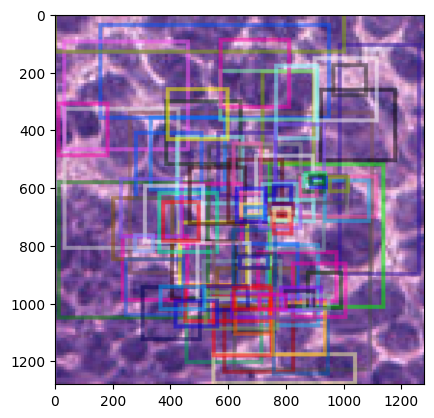

In [110]:
v = Visualizer(img, scale=10)
v._default_font_size = 2
# v = v.draw_instance_predictions(outputs["instances"].to("cpu").__getitem__([2]))
v = v.overlay_instances(boxes = outputs["instances"]._fields["pred_boxes"].to("cpu"))
plt.imshow(cv2.cvtColor(v.get_image(), cv2.COLOR_BGR2RGB))
plt.show()

## Inference on test dataset

In [44]:
# from detectron2.evaluation import DatasetEvaluator
# from detectron2.evaluation import inference_on_dataset

In [67]:
 #import the COCO Evaluator to use the COCO Metrics
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

directory = "/dartfs/rc/nosnapshots/V/VaickusL-nb/EDIT_Students/users/Gokul_Srinivasan/SCC-Tumor-Detection/Gokul_files/Nuclei_Detection/Detectron_Detection/output/"

In [68]:
#Call the COCO Evaluator function and pass the Validation Dataset
evaluator = COCOEvaluator("nuclei_detection_test", cfg, False, output_dir="./output")
val_loader = build_detection_test_loader(cfg, "nuclei_detection_test")

WARNING [01/20 23:18:49 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[01/20 23:18:49 d2.evaluation.coco_evaluation]: Trying to convert 'nuclei_detection_test' to COCO format ...
WARNING [01/20 23:18:49 d2.data.datasets.coco]: Using previously cached COCO format annotations at './output/nuclei_detection_test_coco_format.json'. You need to clear the cache file if your dataset has been modified.
[01/20 23:18:50 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|    cell    | 824          |
|            |              |
[01/20 23:18:50 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[01/20 23:18:50 d2.data.common]: Serializing 115 elements to byte tensors and concatenating them all ...
[01/20 23:18:53 d

In [69]:
#Use the created predicted model in the previous step
inference_on_dataset(predictor.model, val_loader, evaluator)

[01/20 23:18:53 d2.evaluation.evaluator]: Start inference on 115 batches
[01/20 23:18:55 d2.evaluation.evaluator]: Inference done 11/115. Dataloading: 0.0011 s/iter. Inference: 0.0379 s/iter. Eval: 0.0039 s/iter. Total: 0.0428 s/iter. ETA=0:00:04
[01/20 23:19:00 d2.evaluation.evaluator]: Total inference time: 0:00:04.868188 (0.044256 s / iter per device, on 1 devices)
[01/20 23:19:00 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.037900 s / iter per device, on 1 devices)
[01/20 23:19:00 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[01/20 23:19:00 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[01/20 23:19:00 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
[01/20 23:19:00 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[01/20 23:19:00 d2.evaluation.fast_eval_api]: COCOev

OrderedDict([('bbox',
              {'AP': 0.39919916810738315,
               'AP50': 1.8385860497225106,
               'AP75': 0.026880519577422837,
               'APs': 0.5919919381699681,
               'APm': 0.010128645966432969,
               'APl': nan}),
             ('segm',
              {'AP': 7.159067316709979e-05,
               'AP50': 0.0007159067316709979,
               'AP75': 0.0,
               'APs': 7.312400368544979e-05,
               'APm': 0.0,
               'APl': nan})])

In [32]:
!nvidia-smi

Tue Jan 17 23:14:13 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:18:00.0 Off |                    0 |
| N/A   34C    P0    51W / 300W |  11271MiB / 32768MiB |      0%   E. Process |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   